In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [3]:
import numpy as np
import torch
import cv2

In [4]:
!pip install ultralytics
from ultralytics.engine.results import Masks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.2/881.2 kB 35.4 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
from PIL import ImageFont, ImageDraw, Image

In [6]:
import matplotlib.pyplot as plt

In [7]:
colors = """
#B52CFF
#348F00
#6B2CFF
#FFFF2C
#FF3535
#FF7A00
#0DA3FF
#FFD700
#20C9A5
#E91E63
#D4AC2B
#8CFF00
#FF007A
#2E91E5
#AFFF3C
#C71585
#FF6F00
#009688
#FFCC00
#4A90E2
#00BCD4
#CDDC39
#FF4081
#795548
#FFC400"""

In [8]:
colors = [np.array([int(c[i:i+2], 16) for i in (1, 3, 5)]) for c in colors.split("\n") if c]

In [9]:
import json

with open("coco_classes_eng.json") as f:
    eng_labels = json.load(f)

with open("coco_classes_ukr.json") as f:
    ukr_labels = json.load(f)

In [10]:
img_path = "img/dog.jpg"

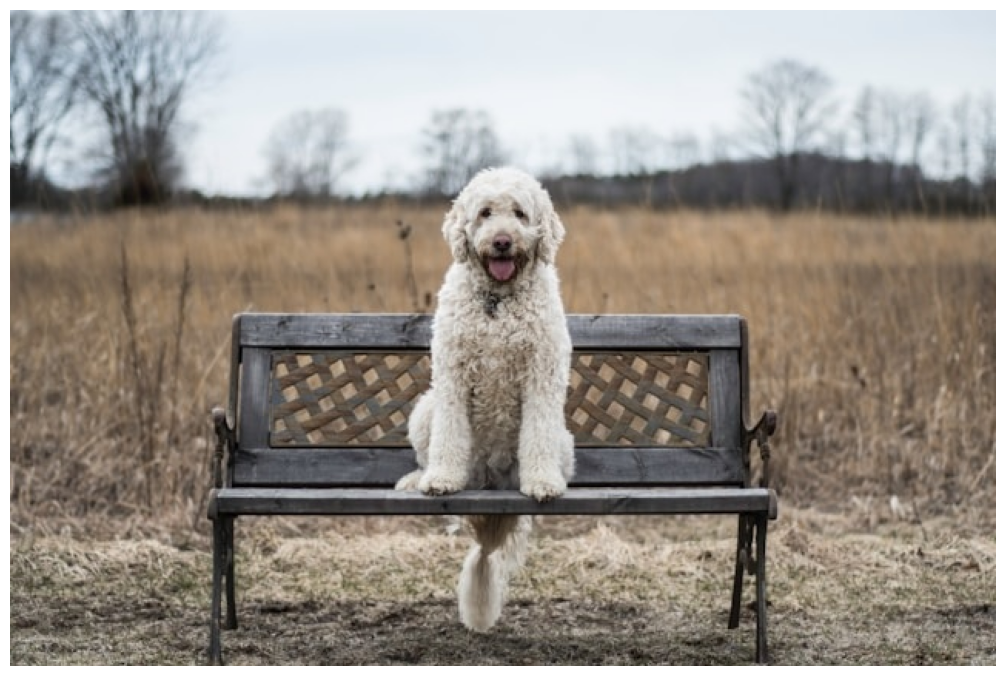

In [17]:
image = cv2.imread(img_path)


# Get the dimensions of the image
height, width, _ = image.shape
# image = cv2.resize(image, (width, height))


# Set the figure size based on the image dimensions
plt.figure(figsize=(width / 50, height / 50))
plt.imshow(image[..., ::-1])
plt.axis('off')  # Hide the axis
plt.show()

In [12]:
from ultralytics import YOLO

# Build a YOLOv9c model from pretrained weight
model = YOLO("yolov9c-seg.pt")

# Display model information (optional)
model.info()

YOLOv9c-seg summary: 654 layers, 27,897,120 parameters, 0 gradients, 159.4 GFLOPs


(654, 27897120, 0, 159.41411839999998)

In [18]:
location = "ukr"

In [19]:
results = model(image)


0: 448x640 1 bench, 1 dog, 109.6ms
Speed: 7.2ms preprocess, 109.6ms inference, 1093.5ms postprocess per image at shape (1, 3, 448, 640)


In [20]:
fontpath = "./fonts/ttNormPro.ttc"
font = ImageFont.truetype(fontpath, 14)

In [21]:
def overlay_masks_on_image(image, results, alpha=0.2, labels=True):
    """
    Overlay masks for multiple instances per class on the original image.

    Args:
        image: Original image (as a NumPy array).
        masks: Dictionary where each key is a class ID, and the value is a list of binary masks (one for each instance).
        alpha: Transparency of the overlay (0 = transparent, 1 = opaque).
    """
    objects = {}
    counters = {}

    for c, mask_obj, box_obj in zip(results[0].boxes.cls.cpu().type(torch.int).numpy(), results[0].masks.xy, results[0].boxes.xyxy):

        # Convert the polygon coordinates to integer
        polygon = np.array(mask_obj, dtype=np.int32)

        # Create a mask for the polygon
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [polygon], 1)

        class_name = ukr_labels[str(c)] if location == "ukr" else eng_labels[str(c)]

        num = counters.get(class_name, 0)
        if num == 0:
            counters[class_name] = 1
            obj_text = class_name
        else:
            counters[class_name] += 1
            obj_text = f"{class_name} {num}"
        objects[obj_text] = {}
        objects[obj_text]["mask"] = mask
        objects[obj_text]["bbox"] = box_obj


        # Get the color for the current class
        color = colors[c % len(colors)]

        # Create a color mask (with the same shape as the image)
        color_mask = np.zeros_like(image)
        color_mask[mask == 1] = color

        # Overlay the mask on the image using the transparency factor
        image = cv2.addWeighted(image, 1, color_mask, alpha, 0)

        # Draw the polygon outline on the image
        image = cv2.polylines(image, [polygon], isClosed=True, color=color.tolist(), thickness=2, lineType=cv2.LINE_AA)

        if labels == True:
            # Find the centroid of the mask to place the label
            moments = cv2.moments(mask)
            if moments["m00"] != 0:
                cX = int(moments["m10"] / moments["m00"])
                cY = int(moments["m01"] / moments["m00"])
                position = (cX, cY)

                # Put the text on the image
                img_pil = Image.fromarray(image)
                draw = ImageDraw.Draw(img_pil)

                bbox = draw.textbbox(position, obj_text, font=font)
                text_width = bbox[2] - bbox[0]
                text_height = bbox[3] - bbox[1]
                centered_position = (position[0] - text_width // 2, position[1] - text_height // 2)

                x1, y1, x2, y2 = draw.textbbox(centered_position, obj_text, font=font)
                # draw.rectangle((x1-5, y1-5, x2+5, y2+5), fill=(250,	246, 245))
                draw.rounded_rectangle((x1-5, y1-5, x2+5, y2+5), fill=(250,	246, 245), radius=8)

                draw.text(centered_position, obj_text, font=font, fill=(0, 0, 0, 255))
                image = np.array(img_pil)

    return image, objects # BINARY masks and bounding boxes

In [22]:
# Overlay masks on the image
output_image, objects = overlay_masks_on_image(image, results)

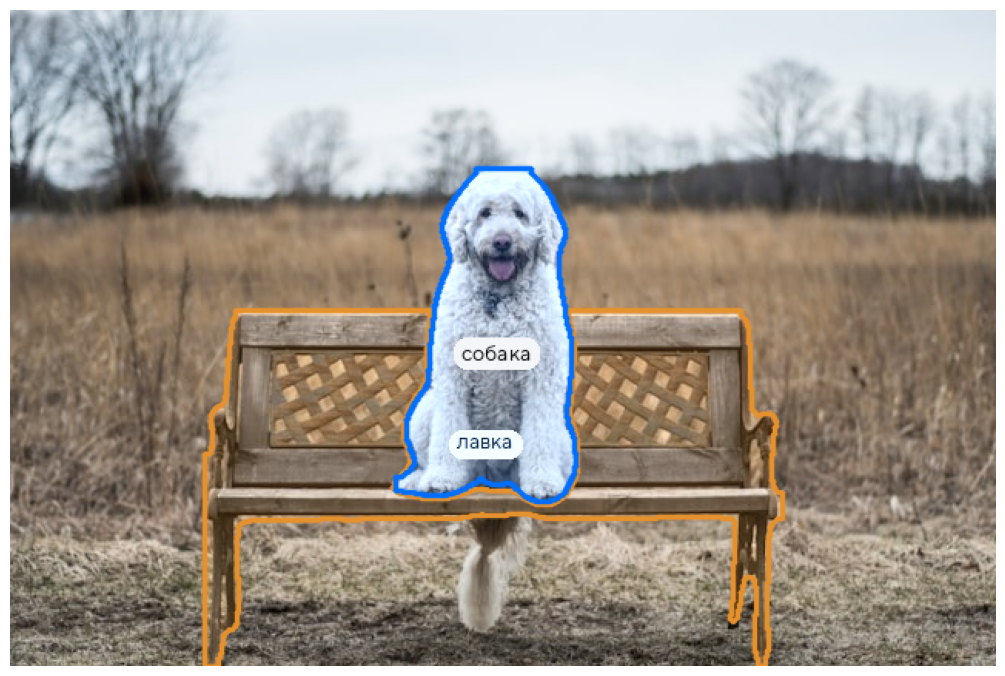

In [24]:
plt.figure(figsize=(width / 50, height / 50))
# Display the image
plt.imshow(output_image[..., ::-1])
plt.axis('off')  # Hide the axis
plt.show()

# Remove the background
Select main object and remove everything behind it

In [25]:
def get_main_object_index(objects):
    # Assuming each object has a 'class' label, 'mask', and 'bbox' (bounding box)
        return max(objects, key=lambda i: np.sum(objects[i]['mask']))  # Largest mask area

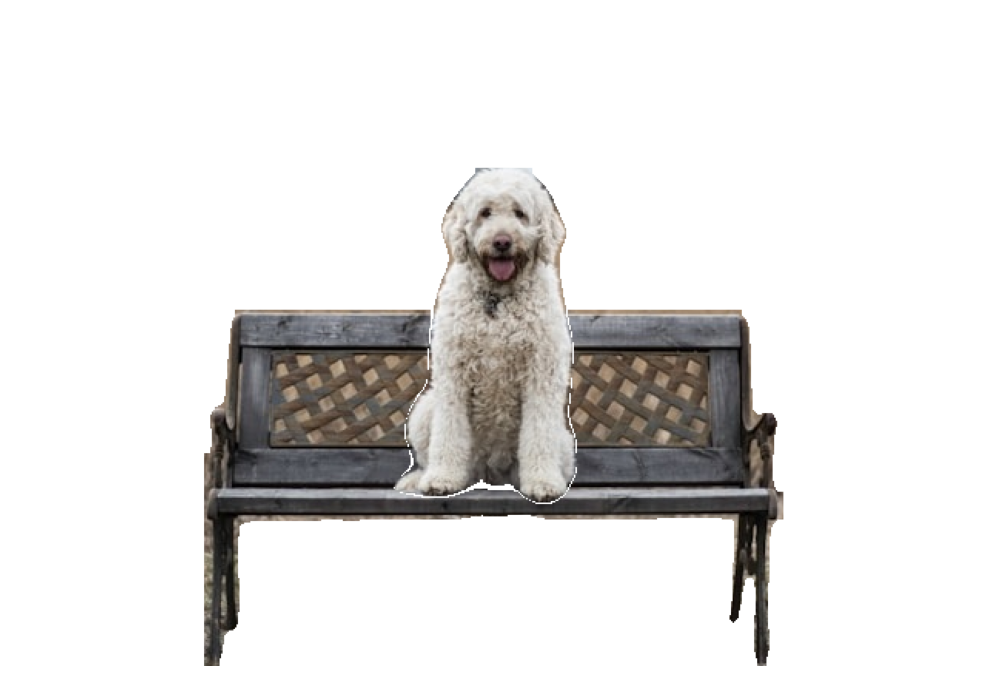

In [27]:
def is_within_proximity(bbox1, bbox2, threshold=20):
    # Calculate if two bounding boxes are within a given pixel proximity threshold
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2

    return (
        abs(x1 - x2) <= threshold or abs(y1 - y2) <= threshold or
        abs((x1 + w1) - (x2 + w2)) <= threshold or abs((y1 + h1) - (y2 + h2)) <= threshold
    )

def combine_masks(objects, main_object_idx, proximity_threshold=20):
    main_object = objects[main_object_idx]
    combined_mask = main_object['mask'].copy()

    for i, obj in enumerate(objects.values()):
        if i != main_object_idx:
            # Check if object is close enough or overlaps with the main object's bounding box
            if is_within_proximity(main_object['bbox'], obj['bbox'], threshold=proximity_threshold):
                combined_mask = cv2.bitwise_or(combined_mask, obj['mask'])  # Add to main mask

    return combined_mask

# Identify the main object and combine masks
main_object_idx = get_main_object_index(objects)
if main_object_idx is not None:
    combined_mask = combine_masks(objects, main_object_idx, proximity_threshold=20)

    # Create a copy of the original image
    background_removed_image = image.copy()

    # Convert the image to RGBA (if it's not already in that format)
    background_removed_image = cv2.cvtColor(background_removed_image, cv2.COLOR_BGR2RGBA)

    # Set the background pixels to transparent
    background_removed_image[combined_mask == 0, 3] = 0

    # Display the image with the background removed
    plt.figure(figsize=(width / 50, height / 50))
    plt.imshow(background_removed_image)
    plt.axis('off')  # Hide the axis
    plt.show()

else:
    print("Main object not found.")


# Cut out an object


In [28]:
!pip install diffusers
!pip install accelerate
!pip install transformers

In [29]:
import torch
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid

pipeline = AutoPipelineForInpainting.from_pretrained("runwayml/stable-diffusion-inpainting")
pipeline = pipeline.to("cuda")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280

In [30]:
init_image = Image.fromarray(image[..., ::-1]).resize((512, 512))

bin_mask = objects['собака']['mask']

# Define the kernel size (you can adjust the size for more or less padding)
kernel_size = 10
kernel = np.ones((kernel_size, kernel_size), np.uint8)

# Dilate the mask
padded_mask = cv2.dilate(bin_mask, kernel, iterations=5)

mask_image = Image.fromarray(padded_mask * 255).convert('RGB').resize((512, 512))

In [31]:
prompt = "blends seamlessly with the surrounding area"
output = pipeline(prompt=prompt, image=init_image, mask_image=mask_image, padding_mask_crop=1).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

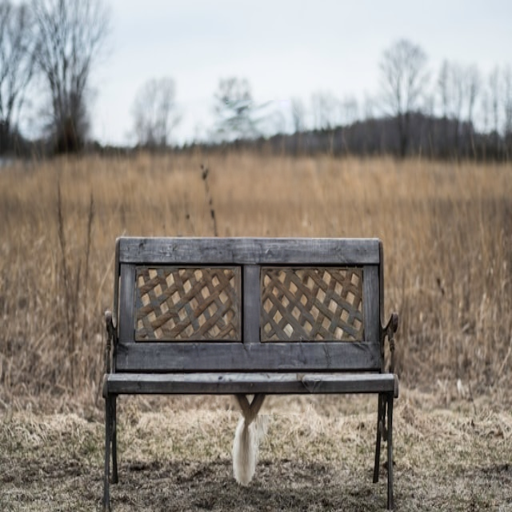

In [32]:
output

# Pick up an object

In [33]:
selected = [objects[i] for i in ["собака"]]

In [34]:
# Merge the selected masks into one
merged_mask = np.zeros_like(selected[0]["mask"], dtype=np.uint8)
for obj in selected:
    merged_mask = cv2.bitwise_or(merged_mask, obj["mask"])

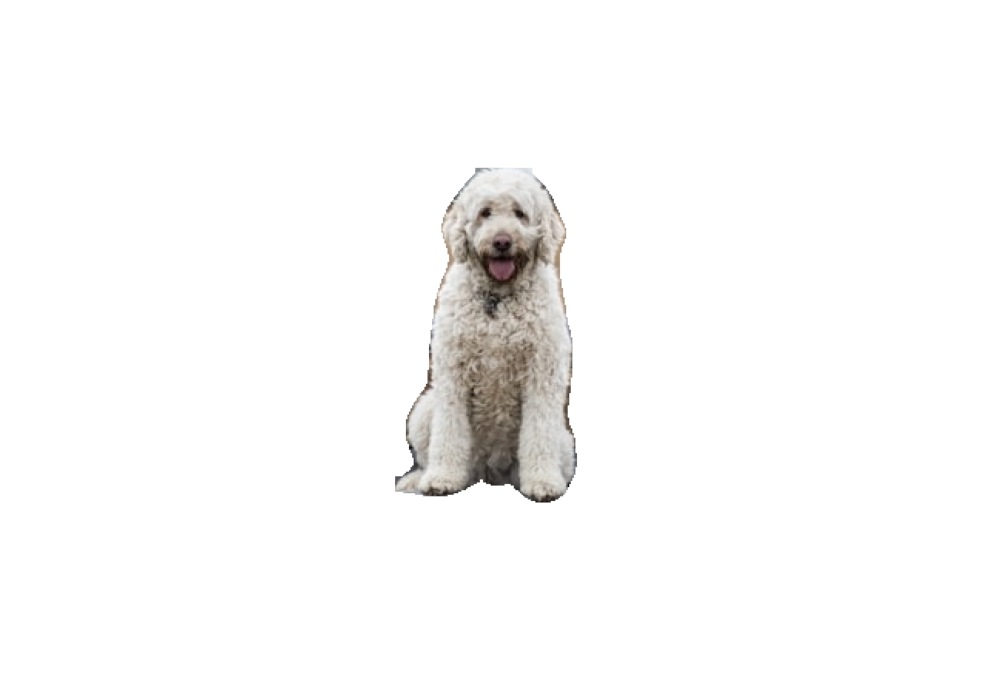

In [36]:
# Create a copy of the original image
pick_up_image = image.copy()

# Convert the image to RGBA (if it's not already in that format)
pick_up_image = cv2.cvtColor(pick_up_image, cv2.COLOR_BGR2RGBA)

# Set the background pixels to transparent
pick_up_image[merged_mask == 0, 3] = 0

# Display the image with the background removed
plt.figure(figsize=(width / 50, height / 50))
plt.imshow(pick_up_image)
plt.axis('off')  # Hide the axis
plt.show()


# Edit the background

In [37]:
selected = [objects[i] for i in ["собака"]]

In [38]:
# Merge the selected masks into one
merged_mask = np.zeros_like(selected[0], dtype=np.uint8)
for obj in selected:
    merged_mask = cv2.bitwise_or(merged_mask, obj["mask"])

In [39]:
background_image = cv2.imread("backgrounds/forest autumn.jpg")

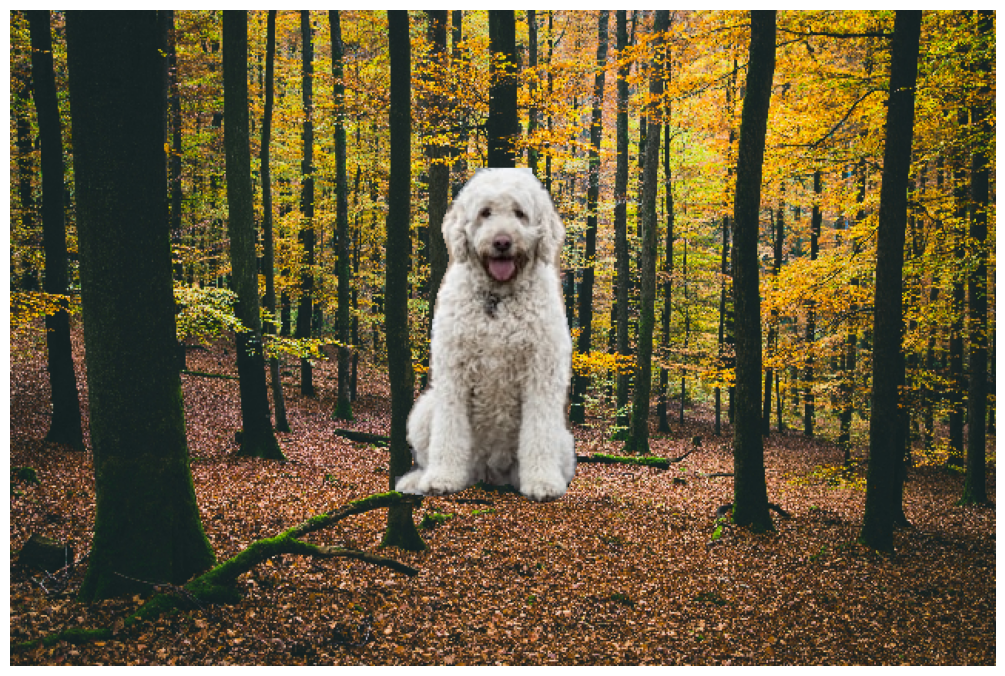

In [40]:
# Resize the background image to match the dimensions of the image
resized_background = cv2.resize(background_image, (image.shape[1], image.shape[0]))

# Overlay the image on top of the resized background
combined_image = resized_background.copy()
combined_image[merged_mask == 1] = image[merged_mask == 1, :3]

# Display the combined image
plt.figure(figsize=(width / 50, height / 50))
plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGRA2RGBA))
plt.axis('off')  # Hide the axis
plt.show()